# Student Exam Performance Prediction

## Importação das bibliotecas

In [169]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
from sklearn.model_selection import train_test_split

import kagglehub
from kagglehub import KaggleDatasetAdapter

## Dataset: Leitura, normalização e visualização dos dados

In [170]:
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "mrsimple07/student-exam-performance-prediction","student_exam_data.csv")
df.head(10)

/tmp/ipython-input-4200986302.py:1: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "mrsimple07/student-exam-performance-prediction","student_exam_data.csv")


Using Colab cache for faster access to the 'student-exam-performance-prediction' dataset.


,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0
5,2.403951,49.757016,0
6,1.522753,94.655631,0
7,8.795585,89.352235,1
8,6.410035,96.987995,1
9,7.372653,83.543171,1


In [171]:
# Separação de Features (X) e Alvo (y)
X = df.drop('Pass/Fail', axis=1).values
Y = df['Pass/Fail'].values

In [172]:
X[:5]

array([[ 4.37086107, 81.88970284],
       [ 9.55642876, 72.16578198],
       [ 7.58794548, 58.57165698],
       [ 6.38792636, 88.82770118],
       [ 2.40416776, 81.08387035]])

In [173]:
Y[:5]

array([0, 1, 0, 1, 0])

In [174]:
# Normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(Xc, Y, test_size=0.2, random_state=42)

# Conversão para tensores PyTorch
#X_train_tensor = torch.FloatTensor(X_train)
#Y_train_tensor = torch.LongTensor(y_train)
#X_test_tensor = torch.FloatTensor(X_test)
#Y_test_tensor = torch.LongTensor(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
Y_test_tensor  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

Shape de X_train: (400, 2)
Shape de X_test: (100, 2)
Shape de y_train: (400,)
Shape de y_test: (100,)


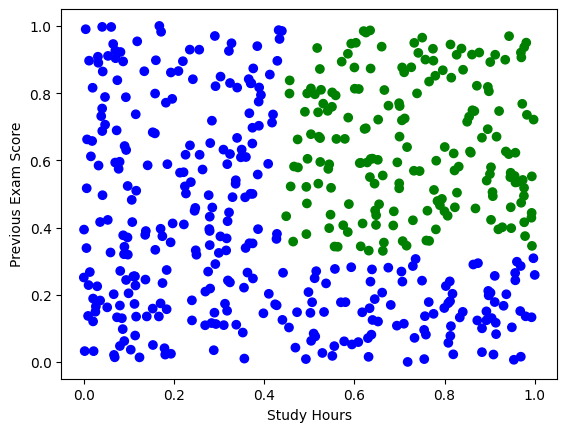

In [175]:
colors = np.array(['b','g'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel("Study Hours")
plt.ylabel("Previous Exam Score")
plt.show()

In [195]:
Y_train_tensor[:5]

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [177]:
X_train_tensor[:10]

tensor([[0.8583, 0.6227],
        [0.0972, 0.5236],
        [0.2897, 0.1465],
        [0.6632, 0.3305],
        [0.0094, 0.1369],
        [0.0845, 0.1300],
        [0.5327, 0.1486],
        [0.6337, 0.1598],
        [0.7620, 0.4500],
        [0.1162, 0.5095]])

## Construindo o modelo da rede

In [178]:
model = nn.Linear(2,1)

In [179]:
model.state_dict()

OrderedDict([('weight', tensor([[0.3231, 0.5681]])),
             ('bias', tensor([-0.2314]))])

### Fazendo um predict

In [180]:
out = model(X_train_tensor[:4,:]) # 4 amostras
out

tensor([[ 0.3996],
        [ 0.0974],
        [-0.0546],
        [ 0.1706]], grad_fn=<AddmmBackward0>)

In [181]:
oo = F.softmax(out,dim=1)
oo

tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

In [182]:
F.softmax(out,dim=1)*100

tensor([[100.],
        [100.],
        [100.],
        [100.]], grad_fn=<MulBackward0>)

### Predição da classe

In [183]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([0, 0, 0, 0])
tensor([1., 1., 1., 1.], grad_fn=<MaxBackward0>)


## Treinamento

In [184]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = LogisticRegressionModel()

### Laço principal de treinamento da Regressão Logística por Softmax

In [185]:
def predict(model, X):
    with torch.no_grad():
        y_pred = model(X)
        return (y_pred >= 0.5).float()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

In [186]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [187]:
nb_epoch = 2000

losses = []
losses_test = []
acc_list = []
acc_test_list = []

for i in range(nb_epoch):
    # predict da rede
    output = model(X_train_tensor)
    output_test = model(X_test_tensor)

    # calcula a perda
    loss = criterion(output, Y_train_tensor)
    loss_test = criterion(output_test, Y_test_tensor)

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())
    losses_test.append(loss_test.data.item())

    _, class_max = torch.max(F.softmax(output,dim=1),dim=1)
    _, class_test_max = torch.max(F.softmax(output_test,dim=1),dim=1)
    acc_list.append((class_max == Y_train_tensor).float().mean())
    acc_test_list.append((class_test_max == Y_test_tensor).float().mean())


    final_loss = loss.data.item()

    if (i+1) % 100 == 0:
        print(f"Epoch {i+1}/{nb_epoch} | Loss = {loss.item():.7f}")

print('Final loss:', final_loss)

Epoch 100/2000 | Loss = 0.5639303
Epoch 200/2000 | Loss = 0.5042797
Epoch 300/2000 | Loss = 0.4623048
Epoch 400/2000 | Loss = 0.4315067
Epoch 500/2000 | Loss = 0.4080729
Epoch 600/2000 | Loss = 0.3896941
Epoch 700/2000 | Loss = 0.3749155
Epoch 800/2000 | Loss = 0.3627835
Epoch 900/2000 | Loss = 0.3526509
Epoch 1000/2000 | Loss = 0.3440641
Epoch 1100/2000 | Loss = 0.3366969
Epoch 1200/2000 | Loss = 0.3303084
Epoch 1300/2000 | Loss = 0.3247173
Epoch 1400/2000 | Loss = 0.3197846
Epoch 1500/2000 | Loss = 0.3154017
Epoch 1600/2000 | Loss = 0.3114829
Epoch 1700/2000 | Loss = 0.3079593
Epoch 1800/2000 | Loss = 0.3047750
Epoch 1900/2000 | Loss = 0.3018844
Epoch 2000/2000 | Loss = 0.2992497
Final loss: 0.29924967885017395


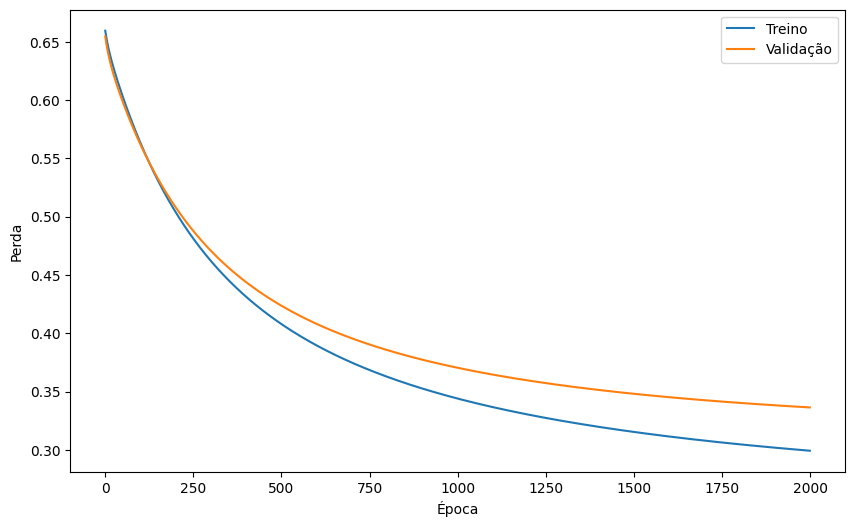

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(nb_epoch)), losses, label='Treino')
plt.plot(list(range(nb_epoch)), losses_test, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

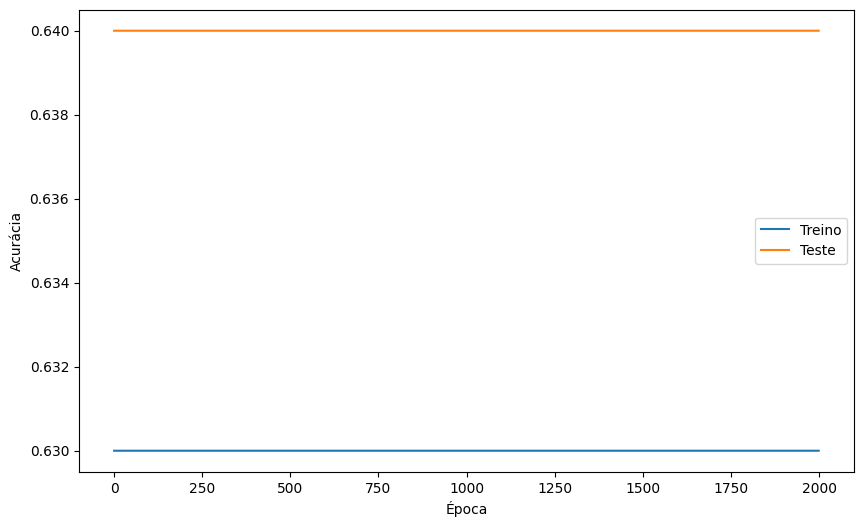

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(nb_epoch)), acc_list, label='Treino')
plt.plot(list(range(nb_epoch)), acc_test_list, label='Teste')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## Exatidão (acurácia) do classificador

In [190]:
# Previsões no treino
Y_pred_train = predict(model, X_train_tensor)

# Garante que ambos são 1D (mesmo formato)
Y_pred_train_flat = Y_pred_train.squeeze()
Y_train_flat      = Y_train_tensor.squeeze()

accuracy_train = (Y_pred_train_flat == Y_train_flat).float().mean().item()
print('Training Accuracy:', accuracy_train)

Training Accuracy: 0.875


In [191]:
Y_pred_test = predict(model, X_test_tensor)
Y_pred_test_flat = Y_pred_test.squeeze()
Y_test_flat      = Y_test_tensor.squeeze()

accuracy_test = (Y_pred_test_flat == Y_test_flat).float().mean().item()
print('Test Accuracy:', accuracy_test)

Test Accuracy: 0.8700000047683716


## Matriz de confusão

In [192]:
# para treino
y_pred_train_np = Y_pred_train.cpu().numpy().reshape(-1)
y_train_np = Y_train_tensor.cpu().numpy().reshape(-1)

# para teste
y_pred_test_np = Y_pred_test.cpu().numpy().reshape(-1)
y_test_np = Y_test_tensor.cpu().numpy().reshape(-1)

In [193]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train_np, y_pred_train_np)
cm_test  = confusion_matrix(y_test_np,  y_pred_test_np)

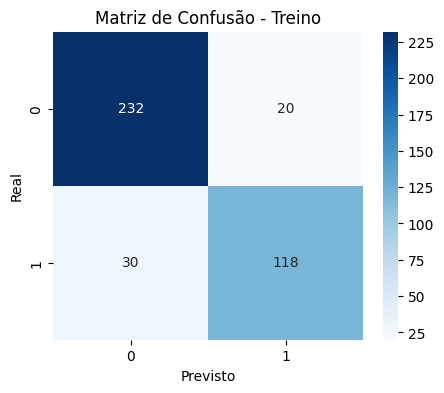

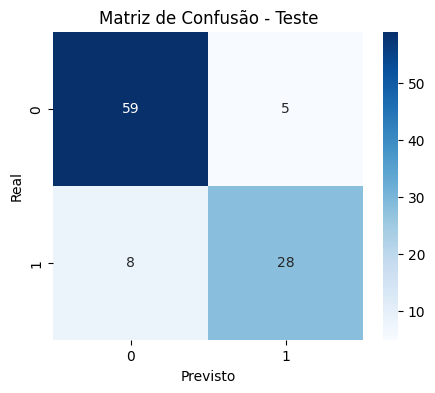

In [194]:
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm_train, "Matriz de Confusão - Treino")
plot_confusion_matrix(cm_test,  "Matriz de Confusão - Teste")